In [1]:
# 📦 Importations
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os

from torch.utils.data import WeightedRandomSampler

In [9]:
# 📂 Préparer les données
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Dataset
train_dataset = datasets.ImageFolder(root="../data/raw/chest_Xray/train", transform=transform)
test_dataset = datasets.ImageFolder(root="../data/raw/chest_Xray/test", transform=transform)
val_dataset = datasets.ImageFolder(root="../data/raw/chest_Xray/val", transform=transform)

# train
class_counts = [train_dataset.targets.count(0), train_dataset.targets.count(1)]
class_weights = 1. / np.array(class_counts)
sample_weights = [class_weights[label] for label in train_dataset.targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)

# test
class_counts = [test_dataset.targets.count(0), test_dataset.targets.count(1)]
class_weights = 1. / np.array(class_counts)
sample_weights = [class_weights[label] for label in test_dataset.targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

test_loader = DataLoader(test_dataset, batch_size=32, sampler=sampler)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

classes = train_dataset.classes

In [3]:
# 🚀 Charger MobileNet pré-entraîné et l'adapter
model = models.mobilenet_v3_small(weights='IMAGENET1K_V1')

# Modifier la dernière couche du classifieur pour deux classes
in_features = model.classifier[3].in_features  # La couche linéaire finale est classifier[3]
model.classifier[3] = nn.Linear(in_features, 2)

# Déplacement sur l'appareil approprié
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

 13%|████████                                                      | 1.75M/13.6M [00:00<00:00, 16.5MB/s]

 28%|█████████████████▏                                            | 3.75M/13.6M [00:00<00:00, 19.0MB/s]

 48%|█████████████████████████████▋                                | 6.50M/13.6M [00:00<00:00, 22.4MB/s]

 72%|████████████████████████████████████████████▌                 | 9.75M/13.6M [00:00<00:00, 26.7MB/s]

100%|██████████████████████████████████████████████████████████████| 13.6M/13.6M [00:00<00:00, 27.9MB/s]

In [4]:
# ⚙️ Définir l'optimiseur et la fonction de perte
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Pour suivre Loss et Accuracy
train_losses = []
train_accuracies = []

In [5]:
# 🏋️ Boucle d'entraînement
epochs = 5

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}%")

Epoch [1/5] - Loss: 0.1745 - Accuracy: 93.18%
Epoch [2/5] - Loss: 0.0750 - Accuracy: 97.26%
Epoch [3/5] - Loss: 0.0658 - Accuracy: 97.74%
Epoch [4/5] - Loss: 0.0444 - Accuracy: 98.64%
Epoch [5/5] - Loss: 0.0458 - Accuracy: 98.37%


Epoch [3/5] - Loss: 0.0385 - Accuracy: 99.04%


Epoch [4/5] - Loss: 0.0320 - Accuracy: 98.88%


Epoch [5/5] - Loss: 0.0180 - Accuracy: 99.52%


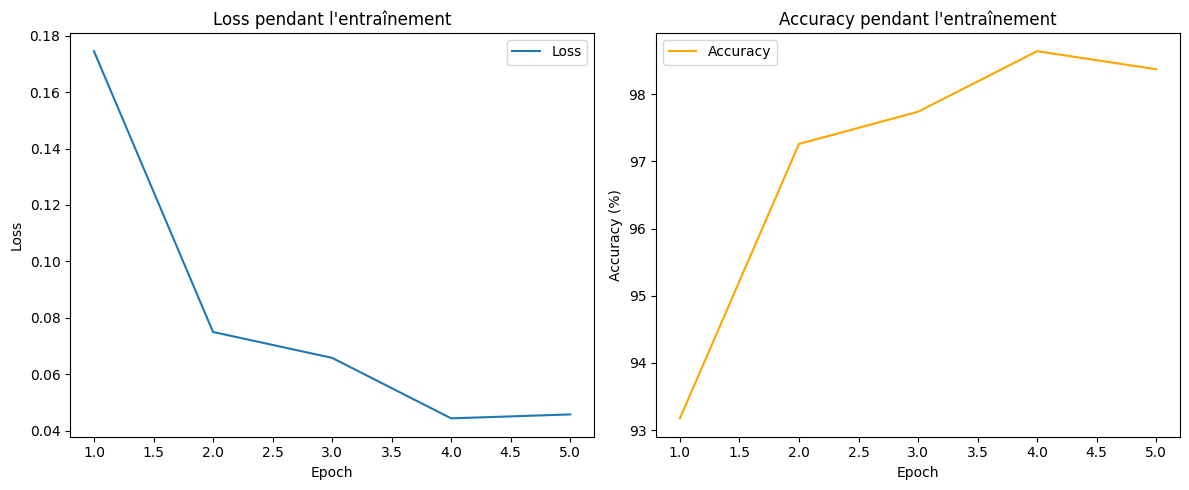

In [6]:
# 📈 Afficher Loss et Accuracy
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss pendant l\'entraînement')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy pendant l\'entraînement')
plt.legend()

plt.tight_layout()
plt.show()

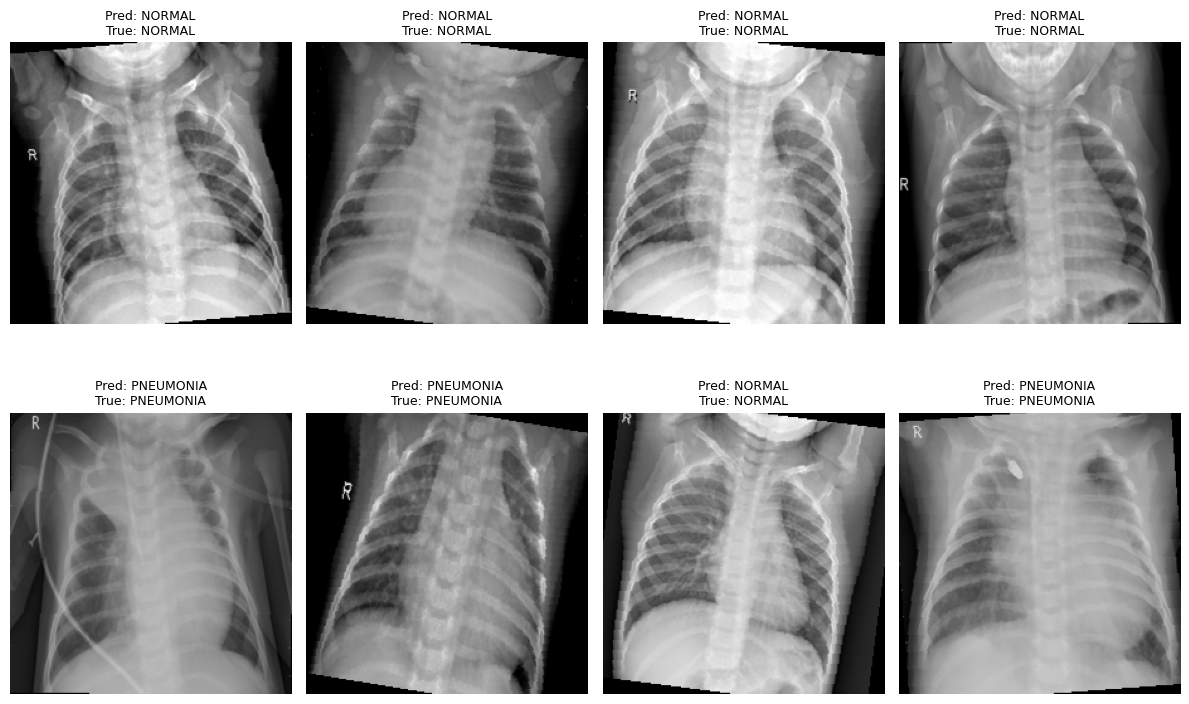

In [10]:
# 🔎 Tester quelques images
model.eval()
inputs, labels = next(iter(train_loader))
inputs, labels = inputs.to(device), labels.to(device)

outputs = model(inputs)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    img = inputs[i].cpu().numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}", fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [11]:
# 💾 Sauvegarder le modèle
torch.save(model.state_dict(), "../models/mobilenet_pneumonia_augmented_data.pth")
print("Modèle sauvegardé ✅")

Modèle sauvegardé ✅
